In [1]:
import pandas as pd

df = pd.read_csv('archive/creditcard.csv')
print(df.head())
print(df['Class'].value_counts(normalize=True))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [2]:
from sklearn.preprocessing import StandardScaler

df['scaled_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

df = df.drop(['Time', 'Amount'], axis=1)

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_bal).value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('Class', axis=1)
y = df['Class']


model = XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_bal, y_train_bal)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.54      0.88      0.67        98

    accuracy                           1.00     56962
   macro avg       0.77      0.94      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

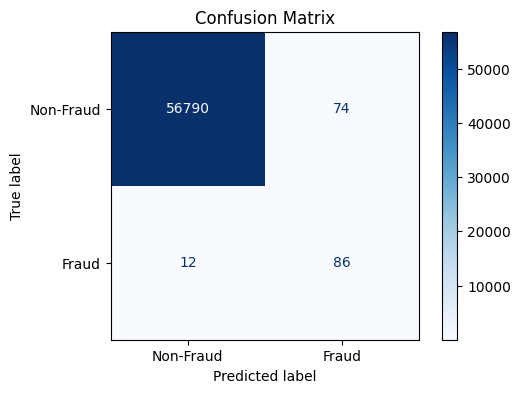

In [7]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

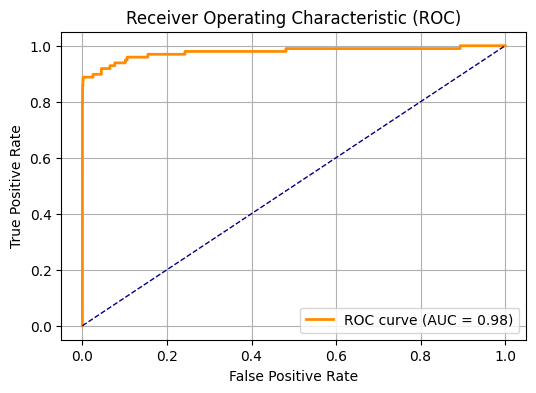

In [8]:
# Get predicted probabilities for the positive class (fraud)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [9]:
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of fraud (class 1)

In [10]:
from sklearn.metrics import precision_score, recall_score

for t in [0.3, 0.5, 0.7, 0.9]:
    y_pred_t = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    print(f"Threshold: {t:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f}")

Threshold: 0.30 | Precision: 0.46 | Recall: 0.89
Threshold: 0.50 | Precision: 0.54 | Recall: 0.88
Threshold: 0.70 | Precision: 0.62 | Recall: 0.86
Threshold: 0.90 | Precision: 0.77 | Recall: 0.84


In [12]:
y_pred_t = (y_proba >= 0.9).astype(int)
print(classification_report(y_test, y_pred_t))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.84      0.80        98

    accuracy                           1.00     56962
   macro avg       0.88      0.92      0.90     56962
weighted avg       1.00      1.00      1.00     56962



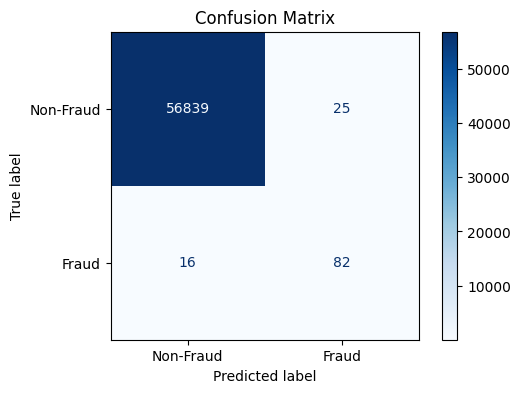

In [13]:
cm = confusion_matrix(y_test, y_pred_t, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])

fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [5]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualize explanation for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [14]:
import pickle

# Save trained model
with open('model/xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Optional: Save the threshold value too
with open('model/threshold.pkl', 'wb') as f:
    pickle.dump(0.9, f)